In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models

In [2]:
import os 
from os import listdir
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

In [4]:
(img_h, img_w) = (160, 160)

In [13]:
def loadImages(path, label):
    arr = np.ndarray([1,img_h, img_w ,3])
    imagesList = listdir(path)
    for image in imagesList:
        img = Image.open(path + image)
        img = np.asarray(img)
        img = cv2.resize(img, (img_h, img_w), interpolation=cv2.INTER_CUBIC)
        img = np.expand_dims(img, axis=0)
        arr = np.append(arr, img, axis = 0)
    arr = arr[1::] 
    return arr

In [14]:
labels = np.array([listdir('./boats')[0::]])

In [15]:
labels_map = {'buoy':0, 'cruise ship':1, 'ferry boat':2, 'freight boat':3, 'gondola':4,
       'inflatable boat':5, 'kayak':6, 'paper boat':7, 'sailboat':8}

In [16]:
data_images = {}
data_labels = {}
for label in labels[0]:
    path = './boats/{}/'.format(label)
    data_images["images_%s" %label] = loadImages(path, label)
    data_labels["label_%s" %label] = np.array([labels_map['%s' %label] 
                                               for x in 
                                           range(data_images["images_%s" %label].shape[0])])
    data_labels["label_%s" %label] = np.expand_dims(data_labels["label_%s" %label],
                                                    axis=1)
    

In [17]:
label = np.concatenate(list(data_labels["label_%s" %label] for label in labels[0])
                        , axis=0)

In [18]:
data = np.concatenate(list(data_images["images_%s" %label] for label in labels[0]), axis=0)

In [20]:
training_idx = np.random.randint(data.shape[0], size=int(np.ceil(data.shape[0]*0.8)))
test_idx = np.random.randint(data.shape[0], size=int(np.floor(data.shape[0]*0.2)))

In [21]:
training_data, training_labels = data[training_idx,:], label[training_idx,:]

In [22]:
test_data, test_labels = data[test_idx,:], label[test_idx,:]

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

In [25]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 50

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [27]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [29]:
base_model.trainable = False

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
print(feature_batch.shape)

(32, 1280)
(32, 5, 5, 1280)


In [32]:
prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
print(feature_batch_average.shape)

(32, 9)
(32, 1280)


In [34]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [35]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [37]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
print(outputs.shape)

(None, 9)


In [38]:
base_learning_rate = 0.001
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [40]:
len(model.trainable_variables)

2

In [41]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)

10/10 [==============================] - 4s 271ms/step - loss: 2.6004 - accuracy: 0.0623


In [42]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/10
37/37 [==============================] - 17s 421ms/step - loss: 1.8308 - accuracy: 0.4238 - val_loss: 1.2234 - val_accuracy: 0.6952
Epoch 2/10
37/37 [==============================] - 17s 465ms/step - loss: 1.0815 - accuracy: 0.6627 - val_loss: 0.9550 - val_accuracy: 0.7363
Epoch 3/10
37/37 [==============================] - 19s 511ms/step - loss: 0.8796 - accuracy: 0.7243 - val_loss: 0.8177 - val_accuracy: 0.7705
Epoch 4/10
37/37 [==============================] - 17s 472ms/step - loss: 0.7493 - accuracy: 0.7543 - val_loss: 0.7570 - val_accuracy: 0.7671
Epoch 5/10
37/37 [==============================] - 17s 468ms/step - loss: 0.6732 - accuracy: 0.7800 - val_loss: 0.6916 - val_accuracy: 0.7740
Epoch 6/10
37/37 [==============================] - 17s 454ms/step - loss: 0.6127 - accuracy: 0.8014 - val_loss: 0.6610 - val_accuracy: 0.7911
Epoch 7/10
37/37 [==============================] - 17s 456ms/step - loss: 0.5385 - accuracy: 0.8176 - val_loss: 0.6529 - val_accuracy: 0.7808

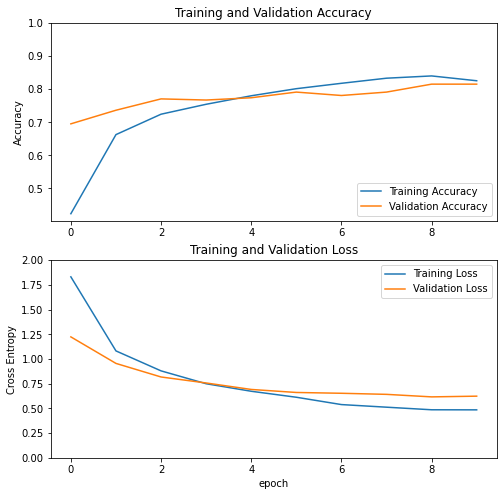

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()